<a href="https://colab.research.google.com/github/Al-Tayeb96/classify-chest-X-rays-as-normal-pneumonia-or-covid-/blob/main/Image_Classification_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image
import PIL
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)



In [6]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs


In [7]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [8]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [9]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [10]:
# Step 1: Unzip the dataset
zip_path = '/content/drive/MyDrive/ CodingDojo/Intermediate ML/computer vison/archive (11).zip'
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [11]:
# Gettting the list of folders from data dir
subfolders = os.listdir(extract_path)
subfolders


['covid', 'normal', 'pneumonia']

In [12]:
# Getting list of img file paths (no folders)
img_files = glob.glob(extract_path+"**/*/*")
len(img_files)



6939

In [13]:
# Take a look at the first 5 filepaths
img_files[0:5]



['/content/dataset/covid/COVID-19 (20).jpg',
 '/content/dataset/covid/COVID19(465).jpg',
 '/content/dataset/covid/COVID19(216).jpg',
 '/content/dataset/covid/COVID-19 (216).jpg',
 '/content/dataset/covid/COVID-19 (357).jpg']

In [14]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape



(1024, 1024, 3)

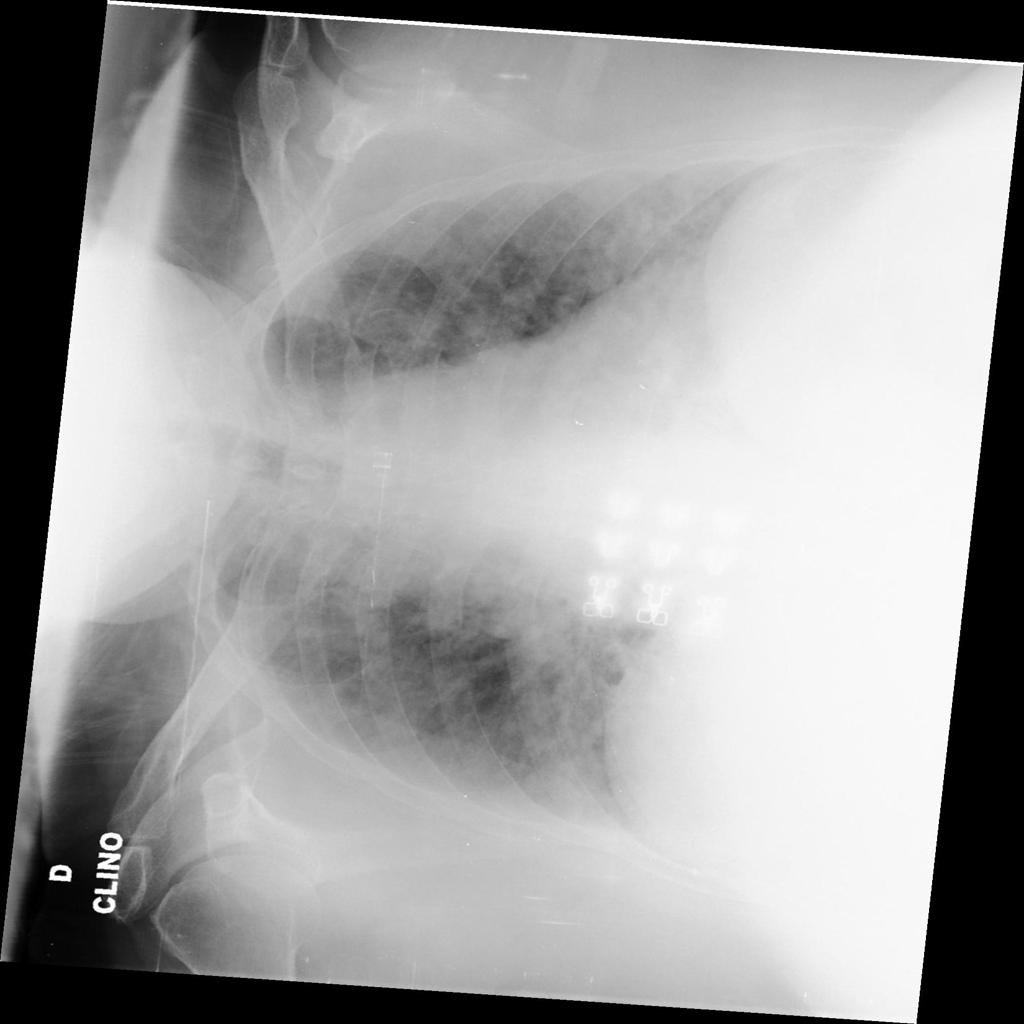

In [15]:
# Data can be converted back to image
array_to_img(img_data)



In [16]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96



In [17]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
 extract_path,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds



Found 6902 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
# checking the class names
class_names = ds.class_names
class_names



['covid', 'normal', 'pneumonia']

In [19]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes



3

In [20]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape



TensorShape([32, 96, 96, 3])

In [21]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict



{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [22]:
# Demo Unpacking shape
input_shape = example_batch_imgs[0].shape

input_shape = [*input_shape]
input_shape



[96, 96, 3]

In [23]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size



216

In [24]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1
# Calculate the number of batches for training and validation data
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")



Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [25]:
# Use .take to slice out the number of batches
train_ds = ds.take(n_train_batches)
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)



43

In [26]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)



22

In [27]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model



In [28]:
# Build the model
model1 = build_model()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0

In [29]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size



151

In [30]:
# Use autotune to automatically determine best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)




In [31]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



In [ ]:
# See how long it takes to fit the optimized dataset
# timing
import datetime as dt
start = dt.datetime.now()
# fit the neural network
epochs=20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=get_callbacks(),
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")



Epoch 1/20
151/151 [==============================] - 128s 553ms/step - loss: 0.6239 - accuracy: 0.7444 - val_loss: 0.5250 - val_accuracy: 0.8270
Epoch 2/20
151/151 [==============================] - 1s 7ms/step - loss: 0.4317 - accuracy: 0.8504 - val_loss: 0.3993 - val_accuracy: 0.8823
Epoch 3/20
151/151 [==============================] - 1s 6ms/step - loss: 0.3558 - accuracy: 0.8820 - val_loss: 0.3610 - val_accuracy: 0.8823
Epoch 4/20
151/151 [==============================] - 1s 8ms/step - loss: 0.3114 - accuracy: 0.8955 - val_loss: 0.3353 - val_accuracy: 0.8983
Epoch 5/20
151/151 [==============================] - 1s 9ms/step - loss: 0.2842 - accuracy: 0.9077 - val_loss: 0.3272 - val_accuracy: 0.8953
Epoch 6/20
151/151 [==============================] - 1s 8ms/step - loss: 0.2555 - accuracy: 0.9166 - val_loss: 0.3376 - val_accuracy: 0.8743
Epoch 7/20
151/151 [==============================] - 1s 6ms/step - loss: 0.2397 - accuracy: 0.9218 - val_loss: 0.3461 - val_accuracy: 0.8939
Tr

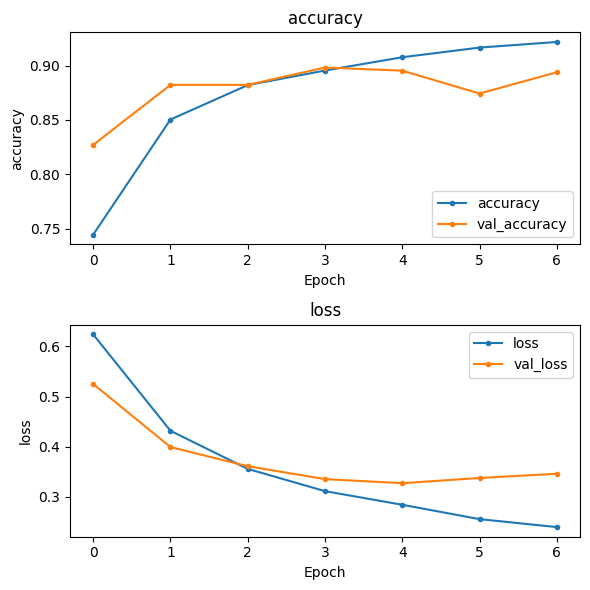


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1587
           1       0.86      0.97      0.91      1623
           2       0.96      0.91      0.94      1622

    accuracy                           0.93      4832
   macro avg       0.93      0.93      0.93      4832
weighted avg       0.93      0.93      0.93      4832



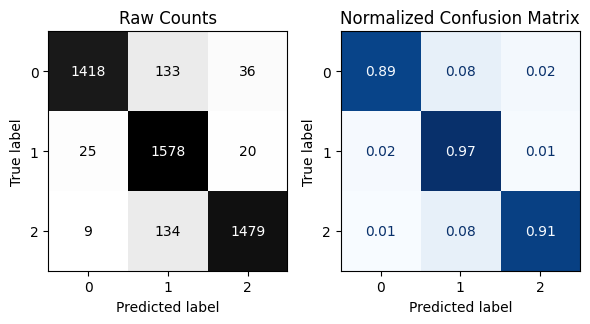


- Evaluating Training Data:
151/151 [==============================] - 1s 5ms/step - loss: 0.2249 - accuracy: 0.9261
{'loss': 0.22488275170326233, 'accuracy': 0.9261175394058228}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       217
           1       0.82      0.96      0.89       256
           2       0.93      0.87      0.90       221

    accuracy                           0.90       694
   macro avg       0.91      0.89      0.90       694
weighted avg       0.90      0.90      0.90       694



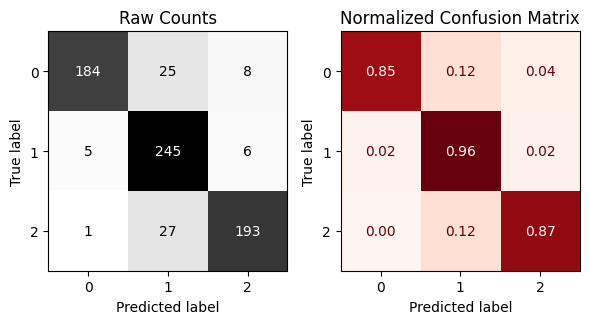


- Evaluating Test Data:
22/22 [==============================] - 0s 11ms/step - loss: 0.3309 - accuracy: 0.8963
{'loss': 0.3308974504470825, 'accuracy': 0.8962535858154297}


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1,X_train=train_ds,X_test=test_ds, history=history);



In [ ]:
!pip install keras-tuner


In [ ]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [ ]:
def build_tune_model_deep(hp):
    model = models.Sequential()
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))
    # Setting hp params and saving as var so they can be used at >1 layer
    n_filters = hp.Int('filters_1',min_value=16, max_value=64, step=16)
    pool_strides = hp.Choice('pool_strides',[1,2])

    model.add(layers.Conv2D(n_filters,
                            # Test using larger kernel size (in first Conv layer ONLY)
                            kernel_size= hp.Choice('kernel_size_1',[3,5]),
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))
    for i in range(hp.Int('n_conv_layers',min_value=1, max_value=3)):
        # Double the number of filters vs. previous layer
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))

        # model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1, max_value=0.5, step=.1)))
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(hp.Float('dropout_rate_dense',min_value=0, max_value=0.5,
                                     step=.1)))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"],
    )
    return model



In [ ]:
# Define the tuner
tuner_hb = kt.Hyperband(build_tune_model_deep, objective='val_accuracy',
                        max_epochs=15, overwrite=True, seed=321,)
# Preivew search summary
tuner_hb.search_space_summary()



Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
pool_strides (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
n_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate_dense (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [ ]:
# Start search
tuner_hb.search(train_ds, validation_data=val_ds, epochs=15,callbacks=get_callbacks())
# Obtain summary of results
tuner_hb.results_summary()



Trial 25 Complete [00h 00m 10s]

Best val_accuracy So Far: 0.9360465407371521
Total elapsed time: 00h 14m 21s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0022 summary
Hyperparameters:
filters_1: 32
pool_strides: 2
kernel_size_1: 3
n_conv_layers: 2
dropout_rate_dense: 0.0
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9360465407371521

Trial 0017 summary
Hyperparameters:
filters_1: 32
pool_strides: 2
kernel_size_1: 3
n_conv_layers: 3
dropout_rate_dense: 0.1
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9353197813034058

Trial 0020 summary
Hyperparameters:
filters_1: 32
pool_strides: 2
kernel_size_1: 5
n_conv_layers: 3
dropout_rate_dense: 0.0
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9338662624359131

Trial 0012 summary
Hyperparameters:
filters_1: 64
pool_strides: 2
kernel_size_1: 5
n_conv_layers: 3
dropo

Best Params: 
 {'filters_1': 32, 'pool_strides': 2, 'kernel_size_1': 3, 'n_conv_layers': 2, 'dropout_rate_dense': 0.0, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1587
           1       0.90      0.99      0.95      1623
           2       0.99      0.92      0.96      1622

    accuracy                           0.96      4832
   macro avg       0.96      0.96      0.96      4832
weighted avg       0.96      0.96      0.96      4832



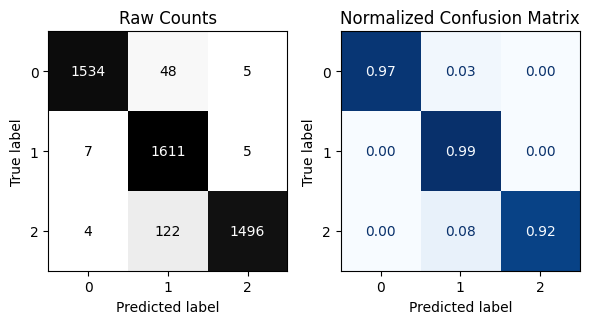


- Evaluating Training Data:
151/151 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9605
{'loss': 0.08238537609577179, 'accuracy': 0.9604718685150146}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       217
           1       0.88      0.98      0.93       256
           2       0.97      0.87      0.92       221

    accuracy                           0.93       694
   macro avg       0.94      0.93      0.93       694
weighted avg       0.94      0.93      0.93       694



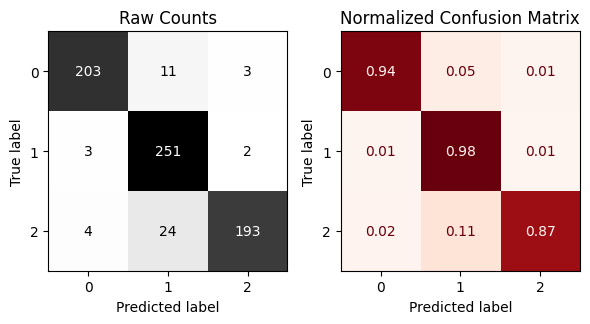


- Evaluating Test Data:
22/22 [==============================] - 0s 17ms/step - loss: 0.1387 - accuracy: 0.9323
{'loss': 0.13865359127521515, 'accuracy': 0.9322766661643982}


In [ ]:
# Print the results for beset paramters
print(f"Best Params: \n {tuner_hb.get_best_hyperparameters()[0].values}" )
# Define the best model
best_model = tuner_hb.get_best_models()[0]
# Evalute the best model with the custom evaluation function
evaluate_classification_network(best_model, X_train=train_ds, X_test=test_ds);



In [32]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)


def build_vgg16_model():
    model = models.Sequential(name="VGG16")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


58889256/58889256 [==============================] - 0s 0us/step


In [33]:
model_vgg16 = build_vgg16_model()
model_vgg16.summary()



Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15895363 (60.64 MB)
Trainable params: 1180675 (

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15895363 (60.64 MB)
Trainable params: 1180675 (

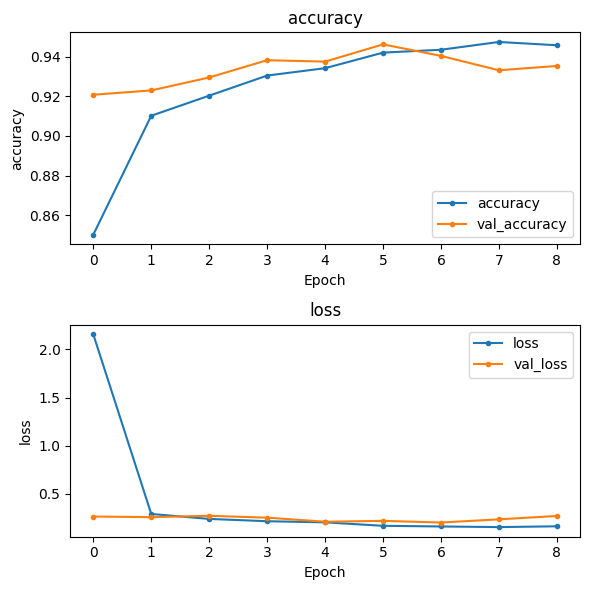


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       217
           1       0.85      0.99      0.92       256
           2       0.98      0.89      0.93       221

    accuracy                           0.93       694
   macro avg       0.94      0.93      0.93       694
weighted avg       0.94      0.93      0.93       694



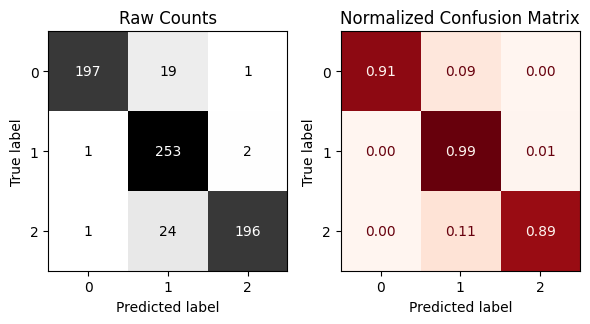


- Evaluating Test Data:
22/22 [==============================] - 2s 86ms/step - loss: 0.2554 - accuracy: 0.9308
{'loss': 0.2553544044494629, 'accuracy': 0.9308357238769531}


In [32]:
model_vgg16=build_vgg16_model()
history = model_vgg16.fit(train_ds, validation_data=val_ds,epochs=20,
                    callbacks=get_callbacks()
                         )
evaluate_classification_network(model_vgg16,X_test=test_ds,history=history);



model_vgg16 is best model


In [34]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a Keras model named 'model'
# Save the model to a file
save_model(model_vgg16, '/content/drive/MyDrive/ CodingDojo/Intermediate ML/COVID_19.h5')


<ipython-input-34-8265453b1d55>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_vgg16, '/content/drive/MyDrive/ CodingDojo/Intermediate ML/COVID_19.h5')
